**DATA PREPARATION**



*   Import Packages



In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import math



*   Read data from a CSV file



In [17]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/XOM.csv')

In [3]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,83.820000,85.199997,83.660004,85.029999,64.879845,11469300
1,2018-01-03,85.160004,86.970001,84.820000,86.699997,66.154083,13957700
2,2018-01-04,86.790001,87.220001,86.430000,86.820000,66.245667,10863000
3,2018-01-05,86.750000,86.879997,85.709999,86.750000,66.192230,11047600
4,2018-01-08,86.699997,87.150002,86.599998,87.139999,66.489830,10927100




*   Visualize the stock price history


Text(0, 0.5, 'Prices ($)')

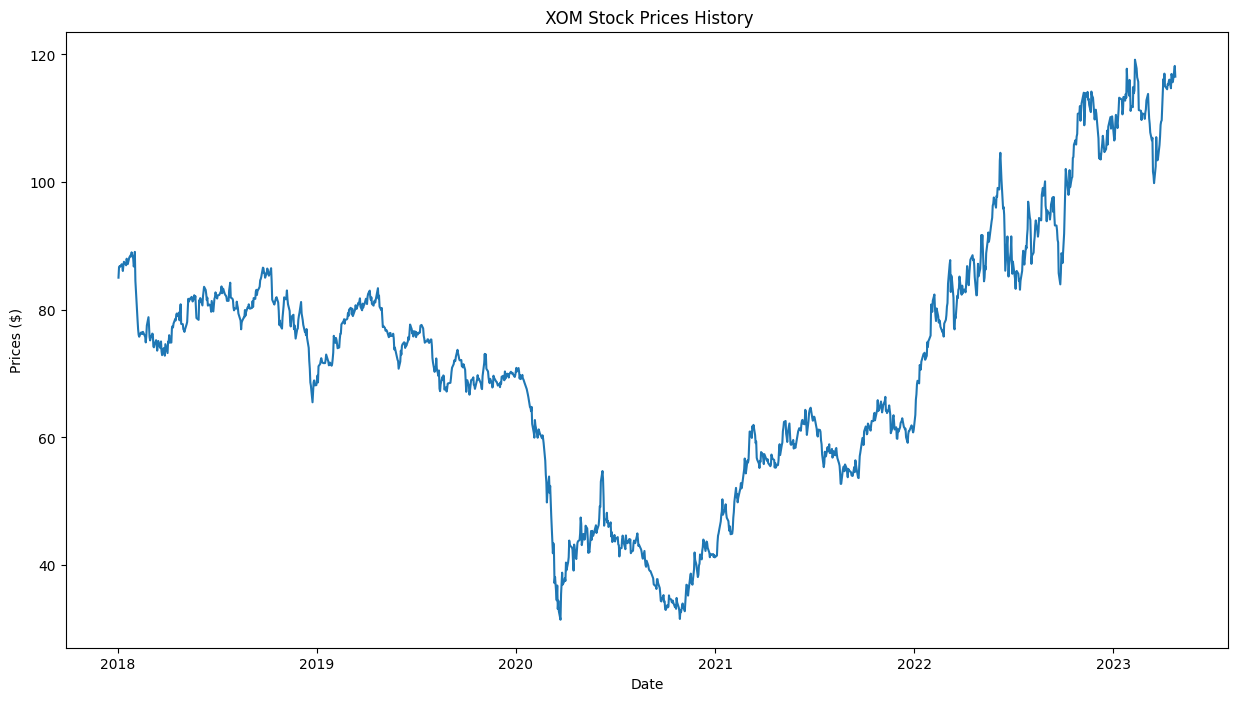

In [18]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

plt.figure(figsize=(15, 8))
plt.title(' XOM Stock Prices History')
plt.plot(data['Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')

**DATA PREPROCESSING**

In [5]:
from numpy import linalg as la
import statistics as stat
from scipy.special import ndtri
from scipy.stats import norm
import random
from sklearn.metrics import mean_squared_error

In [7]:
close_prices = data['Close']
values = close_prices.values

train_size = int(len(close_prices) * 0.7)

train_data = values[:train_size]
test_data = values[train_size:]

**MCMC**

In [8]:
mu, sig, N = 1.1, 1, 100000
pts = []

*In a normal distribution, **mu** represents the mean, **sig** represents
the standard deviation, and **N** represents the number of samples.*

In [6]:
def q(x):
    return (1 / (math.sqrt(2 * math.pi * sig ** 2))) * (math.e ** (-((x - mu) ** 2) / (2 * sig ** 2)))

def MCMC(n):
    r = np.zeros(1)
    p = q(r[0])
    pts = []

    for i in range(N):
        rn = r + np.random.uniform(-1, 1)
        pn = q(rn[0])
        if pn >= p:
            p = pn
            r = rn
        else:
            u = np.random.rand()
            if u < pn / p:
                p = pn
                r = rn
        pts.append(r)

    pts = random.sample(pts, len(pts))
    pts = np.array(pts)
    
    return pts

In [9]:
test_data = np.array(test_data)
stock_pred = []

maturnity = 1
volatility = 0.25
risk_free = 0.1
timestep = 1
steps = len(test_data)
delta_t = maturnity / steps
i = 0
stock_pred.append(train_data[-1])
while timestep < steps:
  stock_price = stock_pred[-i]
  time_exp = maturnity - delta_t * timestep
  # Generate z_t using MCMC method
  pts = MCMC(N)
  stock_price = stock_price * math.exp(((risk_free - 0.5 * (math.pow(volatility, 2))) * delta_t + volatility * math.sqrt(delta_t) * pts[timestep + 5]))
  stock_pred.append(stock_price)
  i = i + 1
  timestep = timestep + 1



*   Evaluate the algorithm's accuracy using RMSE



In [10]:
# Tính MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Tính MDA
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

# Tính toán RMSE, MAPE và MDA
test_rmse = np.sqrt(np.mean((test_data - stock_pred) ** 2))
test_mape = calculate_mape(test_data, stock_pred)
test_mda = calculate_mda(test_data, stock_pred)

# In kết quả
# print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
# print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)
# print('Validation MDA:', valid_mda)
print('Testing MDA:', test_mda)

Testing RMSE: 37.454134878962634
Testing MAPE: 33.50951641894416
Testing MDA: 51.6209476309227


**VISUALIZATION OF PREDICTIONS**



*   Plot 1



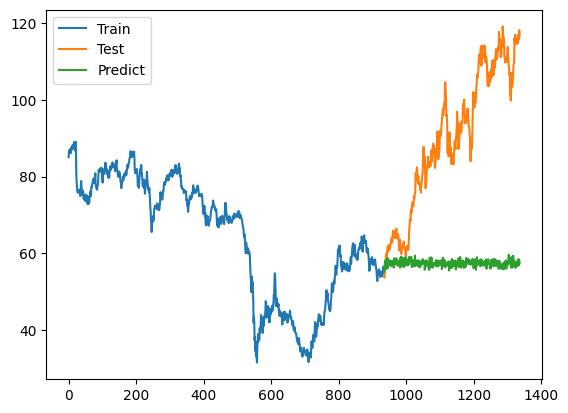

In [12]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data)

test_data_index = pd.RangeIndex(start=train_size, stop=len(close_prices), step=1)
plt.plot(test_data_index,test_data)
test_pre_data_index = pd.RangeIndex(start=train_size, stop=len(close_prices), step=1)
plt.plot(test_pre_data_index,(stock_pred))

plt.legend(['Train','Test','Predict'])
plt.show()



*   Plot 2



In [15]:
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_data_index, y=train_data, mode='lines+markers', marker=dict(size=4),  name='Train', marker_color='#1F77B4'))
fig.add_trace(go.Scatter(x=test_data_index,y=test_data, mode='lines+markers', marker=dict(size=4), name='Test', marker_color='#FF7F0E'))
fig.add_trace(go.Scatter(x=test_pre_data_index,y=stock_pred, mode='lines+markers', marker=dict(size=4), name='Prediction', marker_color='#2CA02C'))

fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  plot_bgcolor='#FFFFFF',  
                  xaxis=dict(gridcolor = 'lightgrey'),
                  yaxis=dict(gridcolor = 'lightgrey'),    
                  title_text = f'XOM MCMC data', title_x = 0.5,
                  xaxis_title="Timestep",
                  yaxis_title="Stock price",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show()